# Defining a Neural Network model in PyTorch and training it on the MNIST dataset

We will now develop a simple neural network in PyTorch to classify the MNIST dataset. We will use the simple feedforward neural network with a single hidden layer we described during the theory lectures.

We will use the `torch.nn` module to define the network and the `torch.optim` module to define the optimizer. We will also use the `torch.utils.data` module to load the MNIST dataset and the `torchvision` module to transform the images.

Let us start by describing these modules and then we will define the network and train it.

## torch.nn

The `torch.nn` module provides the basic building blocks for neural networks. It provides the `Module` class which is the base class for all neural network modules. We can define our own neural network by subclassing `Module` and defining the `forward` method.

For example, the following code defines a simple feedforward neural network with a single hidden layer:



In [1]:
import torch
import torch.nn as nn

EPOCHS = 30
BATCH_SIZE = 10
NUM_HIDDEN = 100
LR = 3.0

# Definizione di una classe per la rete neurale
class SimpleNN(nn.Module):  # Eredita dalla classe nn.Module
    def __init__(self):
        # Inizializzazione della rete neurale, definizione degli strati
        super(SimpleNN, self).__init__()  # Inizializza la classe base nn.Module
        self.fc1 = nn.Linear(784, NUM_HIDDEN)  # Primo strato completamente connesso (questo è lo strato hidden)(input: 784 nodi, output: NUM_HIDDEN nodi)
        self.fc2 = nn.Linear(NUM_HIDDEN, 10)  # Secondo strato completamente connesso (questo è lo strato di output) (input: NUM_HIDDEN, output: 10 nodi)

    def forward(self, x):
        # Definizione del passaggio in avanti (forward pass)
        x = torch.sigmoid(self.fc1(x))  # Applica il primo strato e la funzione di attivazione sigmoid
        x = torch.sigmoid(self.fc2(x))  # Applica il secondo strato e la funzione di attivazione sigmoid
        return x  # Restituisce l'output finale




It is important to note the roles played by the `__init__` and the `forward` methods. The `__init__` method is used to define the layers of the network, i.e., it is the place where the memory for those layers is allocated and the variables that point to it are defined. In this case, we have two fully connected layers. The first layer has 784 input features (the size of the MNIST images) and 128 output features. The second layer has 128 input features and 10 output features (the number of classes in the MNIST dataset).

The `forward` method is used to define the forward pass of the network. It takes the input tensor `x` and applies the layers defined in the `__init__` method to it. In this case, we apply the first fully connected layer and then the ReLU activation function. Finally, we apply the second fully connected layer. Note the idiom `x = torch.relu(self.fc1(x))` which applies the ReLU activation function to the output of the first fully connected layer and stores the result back in `x`. This is a common idiom in PyTorch.

`torch.nn` provides many other modules and activation functions that can be used to define more complex networks. The `Linear` module defines a linear transformation between two layers. We can describe it in terms of the notation we used in the theory lectures: the `__init__` method defines the matrix $\mathbf{W^l}$ and the vector $\mathbf{b^l}$; it's forward method takes as input $\mathbf{z}^{l-1}$ and computes the vector $\mathbf{a}^l = \mathbf{W^l} \mathbf{z}^{l-1} + \mathbf{b^l}$.

## torch.optim

The `torch.optim` module provides the optimizers used to train the neural networks. It provides many optimizers, such as SGD, Adam, RMSprop, etc. The following code defines an optimizer that uses the SGD (vanilla) algorithm:



In [2]:

import torch.optim as optim   # Adam, RMSProp ...

model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=LR)




 The `parameters` method of the model returns an iterator over all the parameters of the model. The optimizer will update these parameters during training. To update the parameters, we need to call the `zero_grad` method of the optimizer to clear the gradients and then call the `step` method to update the parameters.



In [3]:
def train_step(model, optimizer, input, target):
    model.train()

    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, target)#rappresenta una funzione di perdita (o loss function) che misura la differenza tra l'output del modello e il target corretto durante l'allenamento.
    loss.backward() #serve a calcolare il gradiente
    optimizer.step()#i parametri della NN vengono aggiornati
    return loss


You should be able to recognize the pattern from previous PyTorch lectures.

- we first clear the gradients with `optimizer.zero_grad()` (ok, this is the first time we see this);
- we compute the output of the model and the loss: all these operations are tracked by PyTorch's autograd mechanism;
- so that we can then call `loss.backward()` to compute the gradients.

Finally, we call `optimizer.step()` to update the parameters. Note that we are **not** explicitlly passing the parameters to the optimizer, but they are updated because we passed them to the optimizer when we created it.

## torch.utils.data

The `torch.utils.data` module provides classes to load and manipulate datasets. The `Dataset` class is the base class for all datasets. We can define our own dataset by subclassing `Dataset` and defining the `__len__` and `__getitem__` methods. The `__len__` method should return the size of the dataset and the `__getitem__` method should return the $i$-th sample of the dataset.

The `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input a dataset and the batch size. The following code shows how to load the MNIST dataset using the `DataLoader` class:



In [4]:
from torchvision import datasets, transforms  # Importa moduli per gestire dataset comuni e trasformazioni su immagini
from torch.utils.data import DataLoader       # Importa DataLoader, utilizzato per caricare i dati in mini-batch
import torch.nn.functional as F              # Importa funzioni utili per calcoli su tensori, incluso one-hot encoding

# Funzione per convertire i target in formato one-hot
def one_hot_encode(target):
    # Converte un target numerico in una rappresentazione one-hot con 10 classi
    return F.one_hot(torch.tensor(target), num_classes=10).float()

# Definisce una pipeline di trasformazioni da applicare ai dati
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in un tensore PyTorch e normalizza automaticamente i valori in [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalizza i valori per avere media 0 e varianza 1; (0.5,) è per immagini in scala di grigi
])

# Carica il dataset di training MNIST
train_dataset = datasets.MNIST(
    'data',  # Percorso in cui il dataset verrà salvato
    train=True,  # Indica che si tratta del dataset di training
    download=True,  # Scarica il dataset se non è già presente
    transform=transform,  # Applica le trasformazioni definite sopra (ToTensor e Normalize)
    target_transform=one_hot_encode  # Applica il one-hot encoding ai target
)

# Carica il dataset di test MNIST
test_dataset = datasets.MNIST(
    'data',  # Percorso in cui il dataset verrà salvato
    train=False,  # Indica che si tratta del dataset di test
    download=True,  # Scarica il dataset se non è già presente
    transform=transform,  # Applica le trasformazioni definite sopra (ToTensor e Normalize)
    target_transform=one_hot_encode  # Applica il one-hot encoding ai target
)

# Crea un DataLoader per il training set
train_loader = DataLoader(
    train_dataset,  # Dataset da cui caricare i dati
    batch_size=BATCH_SIZE,  # Dimensione di ogni mini-batch
    shuffle=True  # Mescola i dati ad ogni epoca per migliorare il training
)

# Crea un DataLoader per il test set
test_loader = DataLoader(
    test_dataset,  # Dataset da cui caricare i dati
    batch_size=BATCH_SIZE,  # Dimensione di ogni mini-batch
    shuffle=True  # Mescola i dati per garantire una valutazione non sequenziale
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.24MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.58MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw





The `Compose` class is used to chain multiple transformations. In this case, we are using two transformations: `ToTensor` and `Normalize`. The `ToTensor` transformation converts the image to a tensor and scales the pixel values to the range $[0, 1]$. The `Normalize` transformation normalizes the tensor to have zero mean and unit variance.

The `MNIST` class is used to load the MNIST dataset. It takes as input the path where the dataset will be stored, whether it is the training or test set, and the transformations to apply to the images. Finally, the `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input the dataset, the batch size, and whether to shuffle the samples.


Before training the network, let us define a utility function to compute the accuracy of the network on the test set. The following code shows how to do this:

In [5]:
def test(model, test_loader):  # Definisce la funzione che dirà l'accuratezza del modello
    model.eval()  # Imposta il modello in modalità di valutazione (disabilita dropout e batch normalization)
    correct = 0  # Inizializza il contatore per i risultati corretti
    total = 0  # Inizializza il contatore per il numero totale di esempi
    with torch.no_grad():  # Disabilita il calcolo del gradiente per accelerare i calcoli (non necessari durante il test)
        for data in test_loader:  # Ciclo attraverso i mini-batch nel test_loader
            images, labels = data  # Estrai immagini e etichette dal batch corrente
            outputs = model(images.view(-1, 784))  # Passa le immagini attraverso il modello, appiattendo ogni immagine (28x28 -> 784)
            _, predicted = torch.max(outputs.data, 1)  # Trova l'indice della classe con il punteggio più alto (predizione del modello) ignorando il valore effettivo(_)
            _, labels = torch.max(labels.data, 1)  # Trova l'indice della classe corretta nel target (one-hot encoding)
            total += labels.size(0)  # Aggiungi il numero di esempi nel batch al totale
            correct += (predicted == labels).sum().item()  # Aggiungi il numero di predizioni corrette al totale
    return correct / total  # Restituisce la frazione di predizioni corrette, ossia l'accuratezza


Here three things are worth noting.

1. we are using the `torch.no_grad` context manager to disable gradient tracking. This is because we are only interested in computing the accuracy and not in computing the gradients.
2. we are `eval`-ing the model. This is because some layers, such as dropout and batch normalization, behave differently during training and evaluation. We want to evaluate the model in the same way we will use it in production. This is not strictly necessary for the simple network we are using here, but it is a good practice to get into.


We can now train the network using the MNIST dataset. The following code shows how to train the network using the MNIST dataset:

In [6]:
criterion = nn.MSELoss()  # Definisce la funzione di perdita, in questo caso l'errore quadratico medio (MSE)mean squared error per un problema di regressione
losses = []  # Lista per memorizzare i valori di perdita (loss) durante l'allenamento
accuracies = []  # Lista per memorizzare le accuratezze dopo ogni epoca

# Ciclo sulle epoche
for epoch in range(EPOCHS):  # Ripete l'allenamento per il numero definito di epoche
    for i, (images, labels) in enumerate(train_loader):  # Ciclo sui mini-batch del DataLoader per il training
        images = images.view(-1, 784)  # Rende ogni immagine un vettore di dimensione 784 (28x28) per l'input al modello
        loss = train_step(model, optimizer, images, labels)  # Esegui un passo di allenamento: calcola la loss e aggiorna i pesi

        if i % 100 == 0:  # Ogni 100 mini-batch, registra la loss
            losses.append(loss.item())  # Aggiunge il valore della loss corrente alla lista losses

    # Dopo ogni epoca, stampa l'accuratezza corrente sul test set
    print(f"Just completed epoch: {epoch}, current accuracy: {test(model, test_loader)}")  # Stampa l'accuratezza del modello
    accuracies.append(test(model, test_loader))  # Aggiunge l'accuratezza corrente alla lista accuracies


Just completed epoch: 0, current accuracy: 0.9347
Just completed epoch: 1, current accuracy: 0.9515
Just completed epoch: 2, current accuracy: 0.9607
Just completed epoch: 3, current accuracy: 0.9605
Just completed epoch: 4, current accuracy: 0.9664
Just completed epoch: 5, current accuracy: 0.9677
Just completed epoch: 6, current accuracy: 0.9688
Just completed epoch: 7, current accuracy: 0.9716
Just completed epoch: 8, current accuracy: 0.9687
Just completed epoch: 9, current accuracy: 0.9707
Just completed epoch: 10, current accuracy: 0.97
Just completed epoch: 11, current accuracy: 0.9733
Just completed epoch: 12, current accuracy: 0.9725
Just completed epoch: 13, current accuracy: 0.9737
Just completed epoch: 14, current accuracy: 0.9747
Just completed epoch: 15, current accuracy: 0.974
Just completed epoch: 16, current accuracy: 0.9733
Just completed epoch: 17, current accuracy: 0.974
Just completed epoch: 18, current accuracy: 0.9748
Just completed epoch: 19, current accuracy: 0

## Results

Let us print the test accuracy of the network:

In [7]:
print(test(model, test_loader))

0.9758


### Plots

We can also plot the loss and accuracy during training, and samples of the images and their predictions.

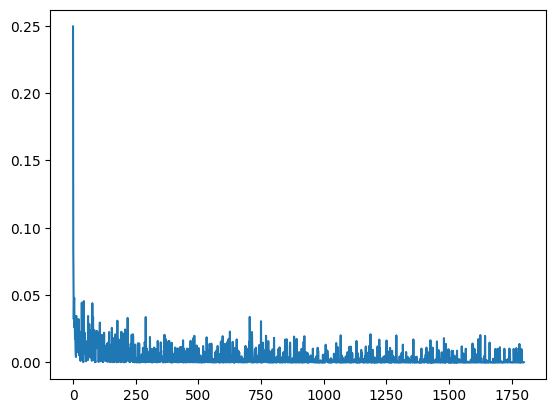

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)

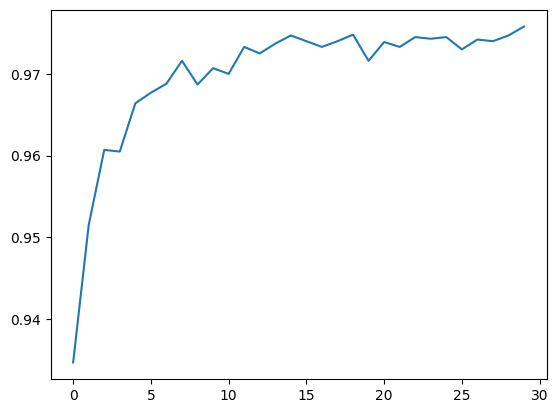

In [9]:
plt.plot(accuracies)

To plot images and their predictions, we start by collecting in three vectors the images, the true labels, and the predicted labels. We then plot a grid of images and their predictions. We use the `imshow` function to plot the images and

In [10]:
model.eval()  # Imposta il modello in modalità di valutazione (disabilita dropout e batch normalization)
labels = []  # Lista per memorizzare le etichette vere (target) durante il test
predicted = []  # Lista per memorizzare le predizioni del modello durante il test
images = []  # Lista per memorizzare le immagini di input durante il test

with torch.no_grad():  # Disabilita il calcolo dei gradienti (non necessario durante il test)
    for data in test_loader:  # Ciclo attraverso i mini-batch del DataLoader di test
        x, y = data  # Estrae le immagini (x) e le etichette (y) dal batch

        y_ = model(x.view(-1, 784))  # Passa le immagini attraverso il modello, appiattendole in un vettore 784 per ogni immagine
        y_ = y_.argmax(axis=1)  # Trova l'indice della classe predetta (la classe con la probabilità più alta) si usa _ per convenzione per identificare le predizioni del modello
        y = y.argmax(axis=1)  # Trova l'indice della classe corretta (dato in formato one-hot)

        labels += y.tolist()  # Aggiunge le etichette vere (y) alla lista 'labels'
        predicted += y_.tolist()  # Aggiunge le predizioni del modello (y_) alla lista 'predicted'
        images += x  # Aggiunge le immagini (x) alla lista 'images'


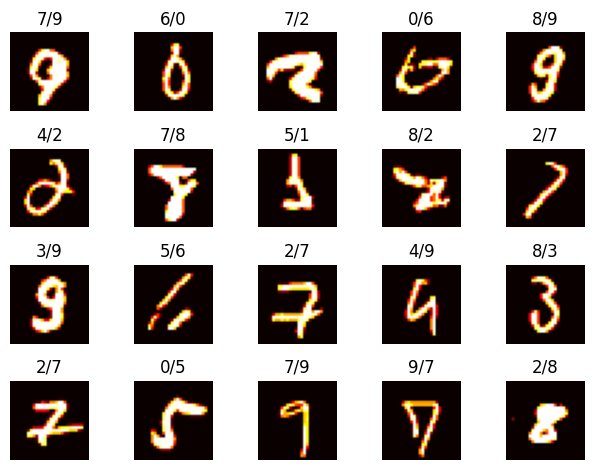

In [11]:

def plot_images(images, predicted, labels):
    fig, axs = plt.subplots(4, 5)
    for i in range(20):
        ax = axs[i // 5, i % 5]

        if predicted[i] == labels[i]:
            ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
        else:
            ax.imshow(images[i].view(28, 28).numpy(), cmap='hot')

        ax.set_title(f"{predicted[i]}/{labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

error_indices = [i for i in range(len(labels)) if labels[i] != predicted[i]]
imgs = [images[i] for i in error_indices]
preds = [predicted[i] for i in error_indices]
labs = [labels[i] for i in error_indices]

plot_images(imgs, preds, labs)